Импортируем необходимые библиотеки, загружаем данные из файликов

Кернелы, к которым я обращалась:

https://www.kaggle.com/code/finlay/two-sigma-eda-and-tree-models

In [28]:
import json
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from scipy import stats
import math

import xgboost as xgb
import sklearn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

In [29]:
# загружаем тренировочный датасет
with open('train.json', 'r') as raw_data:
    train_set = json.load(raw_data)
    df_train = pd.DataFrame(train_set)
    
pd.set_option('display.max_rows', None)

In [30]:
# загружаем тестировочный датасет
with open('test.json', 'r') as raw_data:
    test_set = json.load(raw_data)
    df_test = pd.DataFrame(test_set)

pd.set_option('display.max_rows', None)

In [31]:
df_train.shape

(49352, 15)

In [32]:
df_test.shape

(74659, 14)

In [33]:
# resetting index
# df_train.reset_index(drop = True, inplace = True)

# Предобработка данных

In [34]:
# обрабатываем missing values
missings = df_train.isnull()
for column in missings.columns.values.tolist():
    print(column)
    print (missings[column].value_counts())
    print("")
    

bathrooms
False    49352
Name: bathrooms, dtype: int64

bedrooms
False    49352
Name: bedrooms, dtype: int64

building_id
False    49352
Name: building_id, dtype: int64

created
False    49352
Name: created, dtype: int64

description
False    49352
Name: description, dtype: int64

display_address
False    49352
Name: display_address, dtype: int64

features
False    49352
Name: features, dtype: int64

latitude
False    49352
Name: latitude, dtype: int64

listing_id
False    49352
Name: listing_id, dtype: int64

longitude
False    49352
Name: longitude, dtype: int64

manager_id
False    49352
Name: manager_id, dtype: int64

photos
False    49352
Name: photos, dtype: int64

price
False    49352
Name: price, dtype: int64

street_address
False    49352
Name: street_address, dtype: int64

interest_level
False    49352
Name: interest_level, dtype: int64



Пропущенных значений не обнаружено

In [35]:
# Checking dtypes
df_train.dtypes

bathrooms          float64
bedrooms             int64
building_id         object
created             object
description         object
display_address     object
features            object
latitude           float64
listing_id           int64
longitude          float64
manager_id          object
photos              object
price                int64
street_address      object
interest_level      object
dtype: object

Типы данных не требуют корректировок

In [36]:
df_train.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


### bathrooms
минимальное значение составляет 0, что не совсем логично  
среднее значение составляет 1.21218, это имеет смысл
    
### bedrooms
минимальное значение, как и в случае с прошлой переменной, может свидетельствовать об аномалии или выбросе в данных  
среднее значение вполне логично

### latitude
среднее значение около 40, при этом размах значений от 0.000000 до 44.883500 - возможно в данных присутствуют выбросы

### longitude
среднее значение -73.955716, при этом размах значений от -118.271000 до 0.000000 - возможно наличие выбросов

### price
судя по максимальному значению более 4.49 млн, присутствуют выбросы

Проанализируем зависимую переменную

In [37]:
df_train["interest_level"].value_counts()
# Наибольшее количество сделок сосредоточено в Low interest_level

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64

# Исследование независимых переменных
Как правило, более вариативные признаки являются лучшими предикторами. Те же, которые имеют низкое СКО становятся кандидатами на отсеивание. Наименьшее отклонения имеет переменная bathroom, проанализируем её.

## Bathrooms

In [38]:
df_train['bathrooms'].value_counts()

1.0     39422
2.0      7660
3.0       745
1.5       645
0.0       313
2.5       277
4.0       159
3.5        70
4.5        29
5.0        20
5.5         5
6.0         4
6.5         1
7.0         1
10.0        1
Name: bathrooms, dtype: int64

In [39]:
# Интерпретируем категориальную целевую переменную в числовую, чтобы её удобнее было визуализировать
# https://www.kaggle.com/code/finlay/two-sigma-eda-and-tree-models

df_train['interest'] = np.where(df_train.interest_level == 'low', 0,
                                  np.where(df_train.interest_level == 'medium', 1, 2))

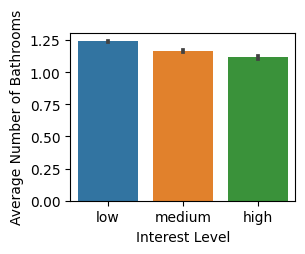

In [40]:
### Average number of Bathrooms per Interest Level

sns.barplot(x = 'interest_level', y = 'bathrooms', data = df_train, order = ['low', 'medium', 'high'],
            ax = plt.subplot(222));
plt.xlabel('Interest Level');
plt.ylabel('Average Number of Bathrooms');

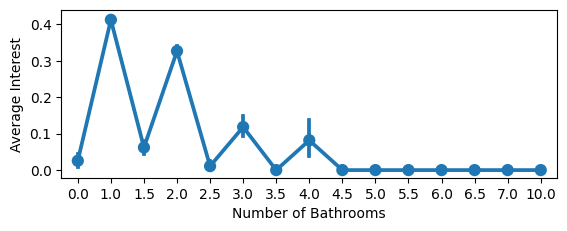

In [41]:
### Average interest for every number of bathrooms
sns.pointplot(x = "bathrooms", y = "interest", data = df_train, ax = plt.subplot(212));
plt.xlabel('Number of Bathrooms');
plt.ylabel('Average Interest');

Из вышеприведённых графиков можно выявить следующую закономерность: с возрастанием количества комнат, идёт тренд на снижение interest_level

<AxesSubplot:xlabel='bathrooms', ylabel='count'>

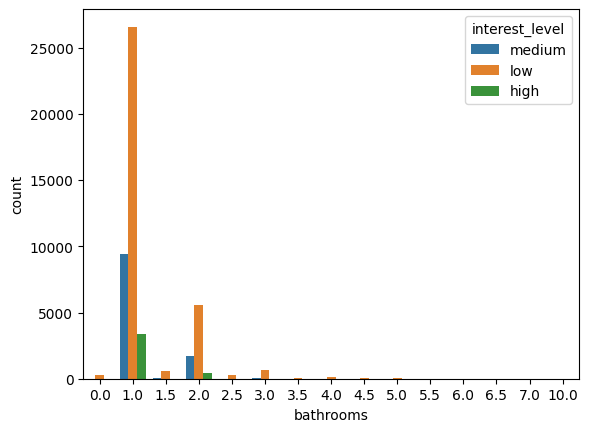

In [42]:
sns.countplot(x = df_train["bathrooms"], hue = df_train['interest_level'])

# Bedrooms

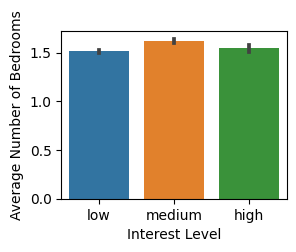

In [43]:
sns.barplot(x = 'interest_level', y = 'bedrooms', data = df_train, order = ['low', 'medium', 'high'],
            ax = plt.subplot(222));
plt.xlabel('Interest Level');
plt.ylabel('Average Number of Bedrooms');

<AxesSubplot:xlabel='bedrooms', ylabel='count'>

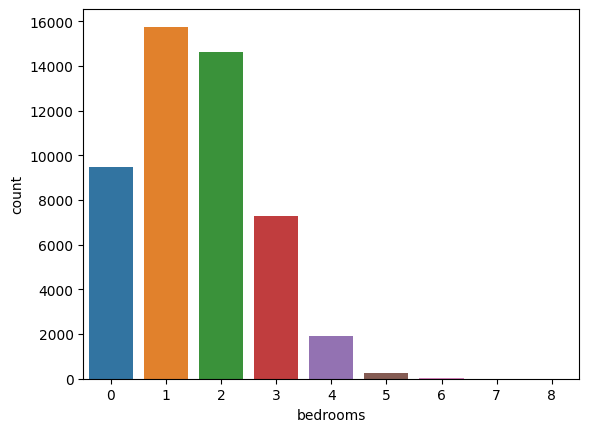

In [44]:
sns.countplot(x = df_train["bedrooms"])

<AxesSubplot:xlabel='bedrooms', ylabel='count'>

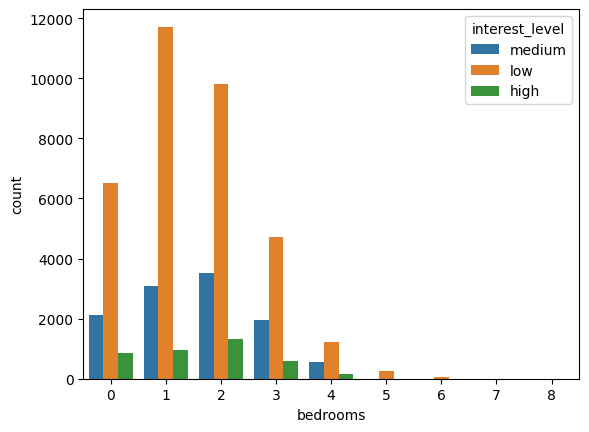

In [45]:
sns.countplot(x = df_train["bedrooms"], hue = df_train['interest_level'])

# Price

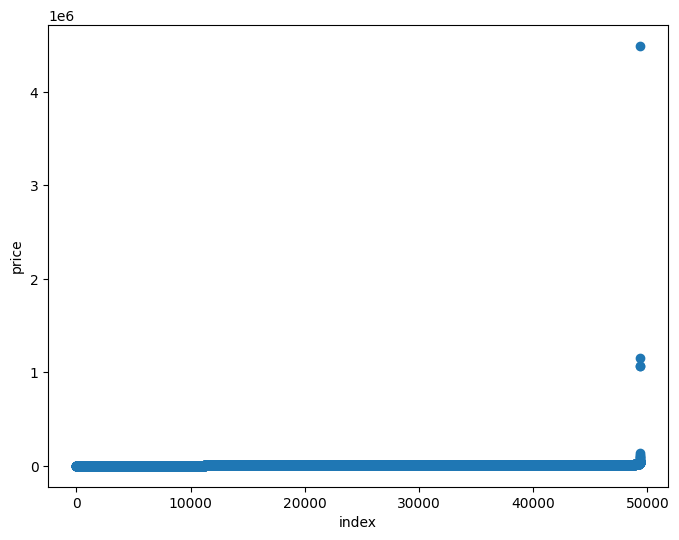

In [46]:
plt.figure(figsize=(8,6))
plt.scatter(range(df_train.shape[0]), np.sort(df_train['price'].values))
plt.xlabel('index')
plt.ylabel('price')
plt.show()

На графике можем увидеть выбросы данных. Будем их корректировать

In [58]:
print(np.where(df_train['price'] > 100000))

(array([ 1830,  4793, 12947, 22058, 22968, 49289], dtype=int64),)


In [59]:
import sklearn
from sklearn.datasets import load_boston
import pandas as pd

In [60]:
# IQR
Q1 = np.percentile(df_train['price'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df_train['price'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

In [61]:
IQR

1600.0

In [62]:
# Верхняя граница
upper = np.where(df_train['price'] >= (Q3 + 1.5 * IQR))
# Нижняя граница
lower = np.where(df_train['price'] <= (Q1 - 1.5 * IQR))

In [63]:
#  Удалим выбросы! 
df_train.drop(upper[0], inplace = True)
df_train.drop(lower[0], inplace = True)

KeyError: '[5 9 50 ... 49306 49310 49319] not found in axis'

In [ ]:
df_train.shape

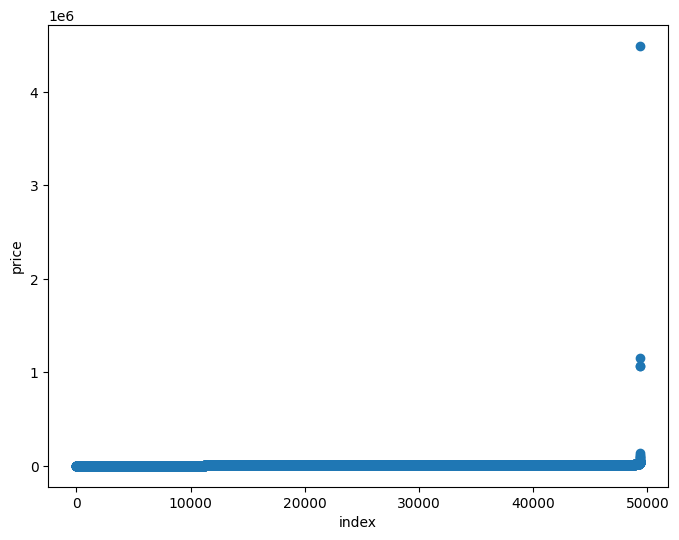

In [53]:
plt.figure(figsize=(8,6))
plt.scatter(range(df_train.shape[0]), np.sort(df_train['price'].values))
plt.xlabel('index')
plt.ylabel('price')
plt.show()

Теперь мы видим закономерный график: чем больше цена, тем больше предложение на рынке. Значит, выбросы удалены

c:\users\lenovo\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


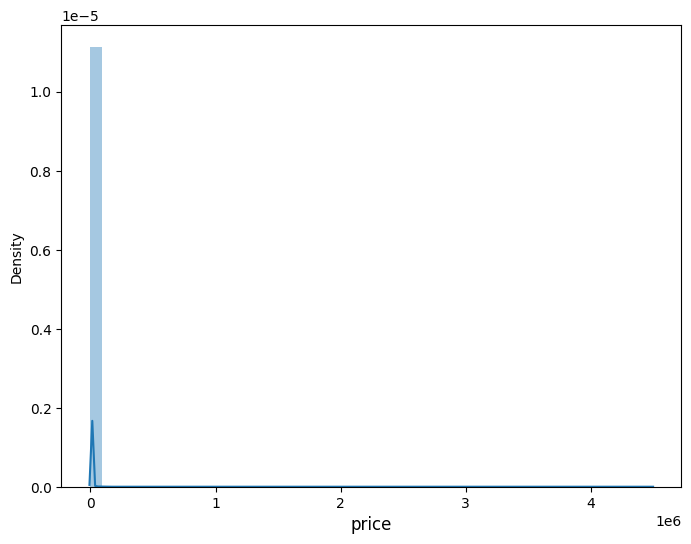

In [57]:
plt.figure(figsize = (8,6))
sns.distplot(df_train.price.values, bins = 50, kde = True)
plt.xlabel('price', fontsize = 12)
plt.show()

In [56]:
from scipy.stats import skew
from scipy.stats import kurtosis
skew(df_train.price, axis = 0, bias = True), kurtosis(df_train.price, axis = 0, bias = True)

(177.68860103258388, 34979.494263424705)

Положительная асимметрия, равная 0.7771428305897755 указывает на то, что распределение положительно искажено; куртозис, равный 0.08851107761819366, свидетельствует, что в нашем распредлении будет меньше выбросов, чем в нормальном.


# XGBoost

По аналогии с Кернелом https://www.kaggle.com/code/sudalairajkumar/xgb-starter-in-python/notebook решила попробовать XGBoost для данной задачи. 

In [ ]:
'''
def data_transform(df_train, df_test):
        
    Y_train = df_train['interest_level']
    df_train = df_train.drop('interest_level', axis = 1)
    
    # нам понадобится разбивка 'created' по промежуткам времени
    dt = pd.concat([df_train, df_test])
    
    dt['created'] = pd.to_datetime(dt['created'])
    dt['year_created'] = dt['created'].dt.year
    dt['month_created'] = dt['created'].dt.month
    dt['day_created'] = dt['created'].dt.day
    dt['hour_created'] = dt['created'].dt.hour
    
    # bedroom_price
    dt['bedroom_price'] = dt['price'] / dt['bedrooms']
    dt.loc[dt['bedrooms'] == 0, 'bedroom_price'] = dt['price']

    # room_count
    dt['room_count'] = dt['bedrooms'] + dt['bathrooms']

    # description_word_count column definition
    dt['description_word_count'] = dt['description'].apply(lambda desc: len(desc.split(' ')))

    # features_word_count column definition
    dt['features_word_count'] = dt['features'].apply(len)

    # photo_count column definition
    dt['photo_count'] = dt['photos'].apply(len)
    
    # columns encoding
    for column_name in ['building_id', 'display_address', 'manager_id', 'street_address']:
        label_encoder = LabelEncoder()
        label_encoder.fit(dt[column_name].values)
        dt[column_name] = label_encoder.transform(dt[column_name].values)
        
    # features transform
    dt['features'] = dt['features'].apply(lambda x: ' '.join(['_'.join(i.split(' ')) for i in x]))
    
    X_train = dt.iloc[:len(df_train)]
    X_test = dt.iloc[len(df_train):]
    
    count_vec = CountVectorizer(max_features=200)
    train_features_token_counts = count_vec.fit_transform(X_train['features'])
    test_features_token_counts = count_vec.transform(X_test['features'])

    # columns drop
    X_train = X_train.drop(['description', 'photos', 'created', 'features'], axis=1)
    X_test = X_test.drop(['description', 'photos', 'created', 'features'], axis=1)
    
    X_train = pd.concat([X_train.reset_index(), pd.DataFrame(train_features_token_counts.toarray(), columns=count_vec.get_feature_names())], axis=1)
    X_test = pd.concat([X_test.reset_index(), pd.DataFrame(test_features_token_counts.toarray(), columns=count_vec.get_feature_names())], axis=1)
    
    return X_train, X_test, Y_train


X_train, X_test, Y_train = data_transform(df_train, df_test)
print(X_train.shape)
print(Y_train.shape)
'''


In [ ]:
# data_transform(df_train, df_test)